# Projeto de Mineração de Dados

## Introdução & Proposta

O presente projeto-experimento tem por finalidade apresentar um classificador de produtos com base na descrição destes. Este projeto realiza experimentos a partir de três modelos-algoritmos: Decision Tree, Naive Bayes e Support-Vector Machine. As seguintes técnicas de pré-processamento são utilizadas neste experimento: `Count Vectorizer` com e sem remoção de *stopwords*; `TF-IDF Vectorizer` com e sem remoção de *stopwords*; `Count Vectorizer` + `TF-IDF Vectorizer` com e sem remoção de *stopwords*; e experimentos com *Unigram*, *Bigram* e *Trigram*.

A acurácia dos modelos propostos é avaliada a partir da métrica **F1 Score**. Ao final, os experimentos são comparados a partir desta métrica.

## Obtenção da base de dados

In [1]:
!ls -all -h datasets/produtos.csv

-rw-r--r-- 1 earaujoassis users 3.7M Aug 27 23:53 datasets/produtos.csv


## Definições comuns aos modelos de análise

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import pandas as pd
import nltk
import re
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def remove_stopwords_and_punctuation(docs):
    stop_words = set(stopwords.words("portuguese"))
    neo_docs = []

    for sentence in docs:
        cleanr = re.compile('<.*?>')
        sentence = re.sub(r'\d+', '', sentence)
        sentence = re.sub(cleanr, '', sentence)
        sentence = re.sub("'", '', sentence)
        sentence = re.sub(r'\W+', ' ', sentence)
        sentence = sentence.replace('_', '')
        sentence = [word for word in sentence.lower().split() if word not in stop_words]
        sentence = ' '.join(sentence)
        neo_docs.append(sentence)

    return neo_docs

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/earaujoassis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df_master = pd.read_csv("datasets/produtos.csv", encoding="utf-8", index_col=0, sep=';')

In [7]:
list(df_master.head())

['descricao', 'categoria']

In [8]:
df_master[['descricao', 'categoria']]

,descricao,categoria
nome,,
O Hobbit - 7ª Ed. 2013,Produto NovoBilbo Bolseiro é um hobbit que lev...,livro
Livro - It A Coisa - Stephen King,Produto NovoDurante as férias escolares de 195...,livro
Box As Crônicas De Gelo E Fogo Pocket 5 Livros,Produto NovoTodo o reino de Westeros ao alcanc...,livro
Box Harry Potter,Produto Novo e Físico A série Harry Potter ch...,livro
Livro Origem - Dan Brown,Produto NovoDe Onde Viemos? Para Onde Vamos? R...,livro
...,...,...
Zelda: Breath Of The Wild - Expansion Pass - Dlc Pack 1 E 2,ENVIO IMEDIATO APÓS CONFIRMAÇÃOCom este Passe ...,game
Middle Earth Shadow Of Mordor Legion Edition Ps3 - Português,NaN,game
Fifa 17 Ps3 Dublado Em Pt Br Envio Digital Imediato,NaN,game


In [9]:
# Shuffle the data frame and its content/rows/entries and
# remove entries with NaN at `categoria` column
df_master = df_master[pd.notnull(df_master['descricao'])]
df_master = df_master.sample(frac=1).reset_index(drop=True)
df_master[['descricao', 'categoria']]

,descricao,categoria
0,CUPHEAD - XBOX ONE - DIGITALFORMATO DIGITAL. P...,game
1,"A Linha Max está ainda mais completa, isso mes...",maquiagem
2,Frete a 10R$Livro Edgar Alan Poe + Frankenstei...,livro
3,KIT BONECOS VINGADORES LANÇAMENTO!MODELOS: HOM...,brinquedo
4,Skate 3 - Xbox 360 - Edição Platinum HitsJogo ...,game
...,...,...
2911,Produto NovoLucinda Riley já vendeu mais de 10...,livro
2912,Espada Space Laser Dupla - MultikidsCódigo:Esp...,brinquedo
2913,Livro Hobbit - J. R. R. Tolkien - Autor de Sen...,livro
2914,JOGO ORIGINAL. NOVO. LACRADO. PRONTA ENTREGA. ...,game


In [10]:
df_master.categoria.unique()

array(['game', 'maquiagem', 'livro', 'brinquedo'], dtype=object)

In [11]:
number_rows = df_master.shape[0]
traninng_threshold = int(0.40 * number_rows)

In [12]:
training_df = df_master[['descricao', 'categoria']].iloc[0:traninng_threshold]
testing_df = df_master[['descricao', 'categoria']].iloc[traninng_threshold + 1:-1]

In [13]:
training_df

,descricao,categoria
0,CUPHEAD - XBOX ONE - DIGITALFORMATO DIGITAL. P...,game
1,"A Linha Max está ainda mais completa, isso mes...",maquiagem
2,Frete a 10R$Livro Edgar Alan Poe + Frankenstei...,livro
3,KIT BONECOS VINGADORES LANÇAMENTO!MODELOS: HOM...,brinquedo
4,Skate 3 - Xbox 360 - Edição Platinum HitsJogo ...,game
...,...,...
1161,Maleta Maquiagem Infantil Modelo Barbie Desenh...,maquiagem
1162,Assassins Creed Origins - Xbox One - Original ...,game
1163,Franquia InfantilTemática Personagens do Cinem...,brinquedo
1164,Maleta Profissional Grande Com MaquiagemMaleta...,maquiagem


In [14]:
testing_df

,descricao,categoria
1167,Paleta de Pó Facial Ruby Rose HB-7208Uso Profi...,maquiagem
1168,BONECOS DA SÉRIE DRAGON BALLPREÇO DA UNIDADEVÁ...,brinquedo
1169,JOGO ORIGINAL. NOVO. LACRADO. PRONTA ENTREGA. ...,game
1170,PRODUTO PRONTA ENTREGA NO BRASILPRODUTO PRONTA...,maquiagem
1171,Assassins Creed Origins Edição Limitada | Jogo...,game
...,...,...
2910,Você está comprando com a GCM GAMES*Compre com...,game
2911,Produto NovoLucinda Riley já vendeu mais de 10...,livro
2912,Espada Space Laser Dupla - MultikidsCódigo:Esp...,brinquedo
2913,Livro Hobbit - J. R. R. Tolkien - Autor de Sen...,livro


## Preparação, treinamento, predição & análise dos dados


### *DecisionTreeClassifier*

#### *DecisionTreeClassifier* + *CountVectorizer*

In [15]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [16]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [17]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [18]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [19]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [20]:
experiment_01 = f1_score(y_true, y_pred, average=None)
experiment_01

array([0.87294118, 0.91420534, 0.92943548, 0.91622481])

#### *DecisionTreeClassifier* + *CountVectorizer* &mdash; com remoção de *stopwords*

In [21]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [22]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [23]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [24]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [25]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [26]:
experiment_01_sw = f1_score(y_true, y_pred, average=None)
experiment_01_sw

array([0.88676996, 0.92795389, 0.94141414, 0.91264132])

#### DecisionTreeClassifier + TfidfVectorizer

In [27]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [28]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [29]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [30]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [31]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [32]:
experiment_02 = f1_score(y_true, y_pred, average=None)
experiment_02

array([0.86363636, 0.91371994, 0.9287169 , 0.91262136])

#### DecisionTreeClassifier + TfidfVectorizer &mdash; com remoção de *stopwords*

In [33]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [34]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [35]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [36]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [37]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [38]:
experiment_02_sw = f1_score(y_true, y_pred, average=None)
experiment_02_sw

array([0.88862837, 0.91703057, 0.94523327, 0.90309278])

#### *DecisionTreeClassifier* + (*CountVectorizer* + *TfidfVectorizer*)

In [39]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [40]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [41]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [42]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [43]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [44]:
experiment_03 = f1_score(y_true, y_pred, average=None)
experiment_03

array([0.83511269, 0.91725105, 0.91995947, 0.88562434])

#### *DecisionTreeClassifier* + (*CountVectorizer* + *TfidfVectorizer*) &mdash; com remoção de *stopwords*

In [45]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [46]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [47]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [48]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [49]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [50]:
experiment_03_sw = f1_score(y_true, y_pred, average=None)
experiment_03_sw

array([0.86666667, 0.91607397, 0.93948718, 0.88139059])

#### *DecisionTreeClassifier* + Unigram

In [51]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [52]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [53]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [54]:
testing_classes

array(['brinquedo', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [55]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [56]:
experiment_04 = f1_score(y_true, y_pred, average=None)
experiment_04

array([0.85714286, 0.91248207, 0.92721834, 0.91594828])

#### *DecisionTreeClassifier* + Unigram &mdash; com remoção de *stopwords*

In [57]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [58]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [59]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [60]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [61]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [62]:
experiment_04_sw = f1_score(y_true, y_pred, average=None)
experiment_04_sw

array([0.87951807, 0.92131617, 0.93522267, 0.90500511])

#### *DecisionTreeClassifier* + Bigram

In [63]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [64]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [65]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [66]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [67]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [68]:
experiment_05 = f1_score(y_true, y_pred, average=None)
experiment_05

array([0.84222738, 0.90857947, 0.9283552 , 0.90772532])

#### *DecisionTreeClassifier* + Bigram &mdash; com remoção de *stopwords*

In [69]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [70]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [71]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [72]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [73]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [74]:
experiment_05_sw = f1_score(y_true, y_pred, average=None)
experiment_05_sw

array([0.88544153, 0.92550143, 0.94427558, 0.90236382])

#### *DecisionTreeClassifier* + Trigram

In [75]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [76]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [77]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [78]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [79]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [80]:
experiment_06 = f1_score(y_true, y_pred, average=None)
experiment_06

array([0.85681024, 0.90422535, 0.93037336, 0.92094017])

#### *DecisionTreeClassifier* + Trigram &mdash; com remoção de *stopwords*

In [81]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [82]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = DecisionTreeClassifier()
model.fit(frequency_training_docs, training_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [83]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [84]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [85]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [86]:
experiment_06_sw = f1_score(y_true, y_pred, average=None)
experiment_06_sw

array([0.88009592, 0.92528736, 0.93927126, 0.90184049])

### *MultinomialNB*

#### *MultinomialNB* + *CountVectorizer*

In [87]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [88]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [89]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [90]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [91]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [92]:
experiment_11 = f1_score(y_true, y_pred, average=None)
experiment_11

array([0.92231813, 0.91780822, 0.94455446, 0.97777778])

#### *MultinomialNB* + *CountVectorizer* &mdash; com remoção de *stopwords*

In [93]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [94]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [95]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [96]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [97]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [98]:
experiment_11_sw = f1_score(y_true, y_pred, average=None)
experiment_11_sw

array([0.93074119, 0.92243767, 0.94642857, 0.98409332])

#### MultinomialNB + TfidfVectorizer

In [99]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [100]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [101]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [102]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [103]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [104]:
experiment_12 = f1_score(y_true, y_pred, average=None)
experiment_12

array([0.86922061, 0.89757412, 0.93756004, 0.958159  ])

#### MultinomialNB + TfidfVectorizer &mdash; com remoção de *stopwords*

In [105]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [106]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [107]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [108]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [109]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [110]:
experiment_12_sw = f1_score(y_true, y_pred, average=None)
experiment_12_sw

array([0.91254753, 0.91780822, 0.95780177, 0.96450939])

#### *MultinomialNB* + (*CountVectorizer* + *TfidfVectorizer*)

In [111]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [112]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [113]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [114]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'livro', 'livro', 'game'],
      dtype='<U9')

In [115]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [116]:
experiment_13 = f1_score(y_true, y_pred, average=None)
experiment_13

array([0.72700297, 0.83870968, 0.88548242, 0.92879257])

#### *MultinomialNB* + (*CountVectorizer* + *TfidfVectorizer*) &mdash; com remoção de *stopwords*

In [117]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [118]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [119]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [120]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [121]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [122]:
experiment_13_sw = f1_score(y_true, y_pred, average=None)
experiment_13_sw

array([0.8828125 , 0.91304348, 0.94083414, 0.95941727])

#### *MultinomialNB* + Unigram

In [123]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [124]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [125]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [126]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [127]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [128]:
experiment_14 = f1_score(y_true, y_pred, average=None)
experiment_14

array([0.92231813, 0.91780822, 0.94455446, 0.97777778])

#### *MultinomialNB* + Unigram &mdash; com remoção de *stopwords*

In [129]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [130]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [131]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [132]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [133]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [134]:
experiment_14_sw = f1_score(y_true, y_pred, average=None)
experiment_14_sw

array([0.93074119, 0.92243767, 0.94642857, 0.98409332])

#### *MultinomialNB* + Bigram

In [135]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [136]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [137]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [138]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [139]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [140]:
experiment_15 = f1_score(y_true, y_pred, average=None)
experiment_15

array([0.90379747, 0.92984869, 0.94563107, 0.97576396])

#### *MultinomialNB* + Bigram &mdash; com remoção de *stopwords*

In [141]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [142]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [143]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [144]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [145]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [146]:
experiment_15_sw = f1_score(y_true, y_pred, average=None)
experiment_15_sw

array([0.92670807, 0.94068966, 0.95592556, 0.97989418])

#### *MultinomialNB* + Trigram

In [147]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [148]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [149]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [150]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [151]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [152]:
experiment_16 = f1_score(y_true, y_pred, average=None)
experiment_16

array([0.90025575, 0.92729767, 0.9428848 , 0.97689076])

#### *MultinomialNB* + Trigram &mdash; com remoção de *stopwords*

In [153]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [154]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = MultinomialNB()
model.fit(frequency_training_docs, training_classes)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [155]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [156]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype='<U9')

In [157]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [158]:
experiment_16_sw = f1_score(y_true, y_pred, average=None)
experiment_16_sw

array([0.9225    , 0.94101509, 0.95882353, 0.97993664])

### *SVC (Support Vector Classification)*

#### *SVC* + *CountVectorizer*

In [159]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [160]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [161]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [162]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'livro'], dtype=object)

In [163]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [164]:
experiment_21 = f1_score(y_true, y_pred, average=None)
experiment_21

array([0.81510934, 0.82565789, 0.92570281, 0.93002257])

#### *SVC* + *CountVectorizer* &mdash; com remoção de *stopwords*

In [165]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [166]:
vectorizer = CountVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [167]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [168]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'livro'], dtype=object)

In [169]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [170]:
experiment_21_sw = f1_score(y_true, y_pred, average=None)
experiment_21_sw

array([0.85773624, 0.89440994, 0.93172691, 0.93617021])

#### SVC + TfidfVectorizer

In [171]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [172]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [173]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [174]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [175]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [176]:
experiment_22 = f1_score(y_true, y_pred, average=None)
experiment_22

array([0.9540636 , 0.94444444, 0.96340257, 0.97268908])

#### SVC + TfidfVectorizer &mdash; com remoção de *stopwords*

In [177]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [178]:
vectorizer = TfidfVectorizer(analyzer="word")
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [179]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [180]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [181]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [182]:
experiment_22_sw = f1_score(y_true, y_pred, average=None)
experiment_22_sw

array([0.95971564, 0.95930233, 0.96957802, 0.97989418])

#### *SVC* + (*CountVectorizer* + *TfidfVectorizer*)

In [183]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [184]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [185]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [186]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [187]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [188]:
experiment_23 = f1_score(y_true, y_pred, average=None)
experiment_23

array([0.94424674, 0.9505814 , 0.96311067, 0.96049896])

#### *SVC* + (*CountVectorizer* + *TfidfVectorizer*) &mdash; com remoção de *stopwords*

In [189]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [190]:
vectorizer = CountVectorizer(analyzer="word", min_df=1)
frequency_training_docs = vectorizer.fit_transform(training_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_training_docs)
frequency_training_docs = tf_transformer.transform(frequency_training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [191]:
frequency_testing_docs = vectorizer.transform(testing_docs)
tf_transformer = TfidfTransformer(use_idf=False).fit(frequency_testing_docs)
frequency_testing_docs = tf_transformer.transform(frequency_testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [192]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'game'], dtype=object)

In [193]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [194]:
experiment_23_sw = f1_score(y_true, y_pred, average=None)
experiment_23_sw

array([0.95539906, 0.96681097, 0.97492477, 0.96436059])

#### *SVC* + Unigram

In [195]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [196]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [197]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [198]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'livro'], dtype=object)

In [199]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [200]:
experiment_24 = f1_score(y_true, y_pred, average=None)
experiment_24

array([0.81510934, 0.82565789, 0.92570281, 0.93002257])

#### *SVC* + Unigram &mdash; com remoção de *stopwords*

In [201]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [202]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,1))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [203]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [204]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'livro'], dtype=object)

In [205]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [206]:
experiment_24_sw = f1_score(y_true, y_pred, average=None)
experiment_24_sw

array([0.85773624, 0.89440994, 0.93172691, 0.93617021])

#### *SVC* + Bigram

In [207]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [208]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [209]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [210]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'livro'], dtype=object)

In [211]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [212]:
experiment_25 = f1_score(y_true, y_pred, average=None)
experiment_25

array([0.816286  , 0.81983471, 0.92323232, 0.93736018])

#### *SVC* + Bigram &mdash; com remoção de *stopwords*

In [213]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [214]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,2))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [215]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [216]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'livro'], dtype=object)

In [217]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [218]:
experiment_25_sw = f1_score(y_true, y_pred, average=None)
experiment_25_sw

array([0.82985075, 0.87163233, 0.92307692, 0.92881356])

#### *SVC* + Trigram

In [219]:
training_docs = training_df["descricao"].values
training_classes = training_df["categoria"].values
testing_docs = testing_df["descricao"].values

In [220]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [221]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [222]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'livro'], dtype=object)

In [223]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [224]:
experiment_26 = f1_score(y_true, y_pred, average=None)
experiment_26

array([0.81584158, 0.81530782, 0.91809909, 0.9375    ])

#### *SVC* + Trigram &mdash; com remoção de *stopwords*

In [225]:
training_docs = remove_stopwords_and_punctuation(training_df["descricao"].values)
training_classes = training_df["categoria"].values
testing_docs = remove_stopwords_and_punctuation(testing_df["descricao"].values)

In [226]:
vectorizer = CountVectorizer(analyzer="word", ngram_range=(1,3))
frequency_training_docs = vectorizer.fit_transform(training_docs)
model = SVC(gamma='scale')
model.fit(frequency_training_docs, training_classes)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [227]:
frequency_testing_docs = vectorizer.transform(testing_docs)
testing_classes = model.predict(frequency_testing_docs)

In [228]:
testing_classes

array(['maquiagem', 'brinquedo', 'game', ..., 'brinquedo', 'livro',
       'livro'], dtype=object)

In [229]:
y_true = testing_df["categoria"].values
y_pred = testing_classes

In [230]:
experiment_26_sw = f1_score(y_true, y_pred, average=None)
experiment_26_sw

array([0.8076555 , 0.85346216, 0.9125    , 0.91954023])

## Comparativo das soluções

### Experimentos com Decision Tree

In [231]:
experiment_01

array([0.87294118, 0.91420534, 0.92943548, 0.91622481])

In [232]:
experiment_02

array([0.86363636, 0.91371994, 0.9287169 , 0.91262136])

In [233]:
experiment_03

array([0.83511269, 0.91725105, 0.91995947, 0.88562434])

In [234]:
experiment_04

array([0.85714286, 0.91248207, 0.92721834, 0.91594828])

In [235]:
experiment_05

array([0.84222738, 0.90857947, 0.9283552 , 0.90772532])

In [236]:
experiment_06

array([0.85681024, 0.90422535, 0.93037336, 0.92094017])

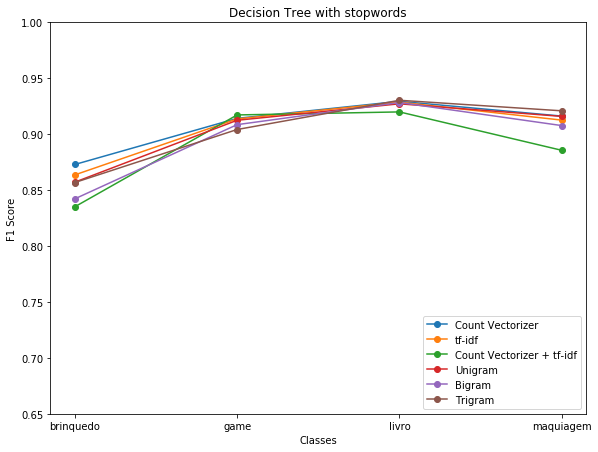

In [237]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('Decision Tree with stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['brinquedo', 'game', 'livro', 'maquiagem'])
ax.set_xticks([0, 1, 2, 3])
ax.set_ylim([0.65,1])
ax.plot(experiment_01,marker="o",label='Count Vectorizer')
ax.plot(experiment_02,marker="o",label='tf-idf')
ax.plot(experiment_03,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_04,marker="o",label='Unigram')
ax.plot(experiment_05,marker="o",label='Bigram')
ax.plot(experiment_06,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

In [238]:
experiment_01_sw

array([0.88676996, 0.92795389, 0.94141414, 0.91264132])

In [239]:
experiment_02_sw

array([0.88862837, 0.91703057, 0.94523327, 0.90309278])

In [240]:
experiment_03_sw

array([0.86666667, 0.91607397, 0.93948718, 0.88139059])

In [241]:
experiment_04_sw

array([0.87951807, 0.92131617, 0.93522267, 0.90500511])

In [242]:
experiment_05_sw

array([0.88544153, 0.92550143, 0.94427558, 0.90236382])

In [243]:
experiment_06_sw

array([0.88009592, 0.92528736, 0.93927126, 0.90184049])

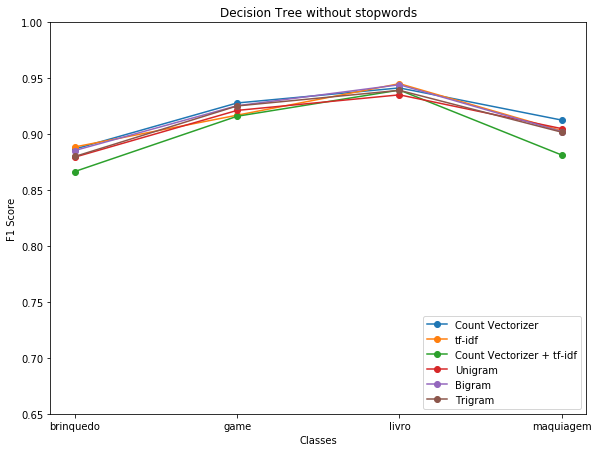

In [244]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('Decision Tree without stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['brinquedo', 'game', 'livro', 'maquiagem'])
ax.set_xticks([0, 1, 2, 3])
ax.set_ylim([0.65,1])
ax.plot(experiment_01_sw,marker="o",label='Count Vectorizer')
ax.plot(experiment_02_sw,marker="o",label='tf-idf')
ax.plot(experiment_03_sw,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_04_sw,marker="o",label='Unigram')
ax.plot(experiment_05_sw,marker="o",label='Bigram')
ax.plot(experiment_06_sw,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

### Experimentos com Naive Bayes

In [245]:
experiment_11

array([0.92231813, 0.91780822, 0.94455446, 0.97777778])

In [246]:
experiment_12

array([0.86922061, 0.89757412, 0.93756004, 0.958159  ])

In [247]:
experiment_13

array([0.72700297, 0.83870968, 0.88548242, 0.92879257])

In [248]:
experiment_14

array([0.92231813, 0.91780822, 0.94455446, 0.97777778])

In [249]:
experiment_15

array([0.90379747, 0.92984869, 0.94563107, 0.97576396])

In [250]:
experiment_16

array([0.90025575, 0.92729767, 0.9428848 , 0.97689076])

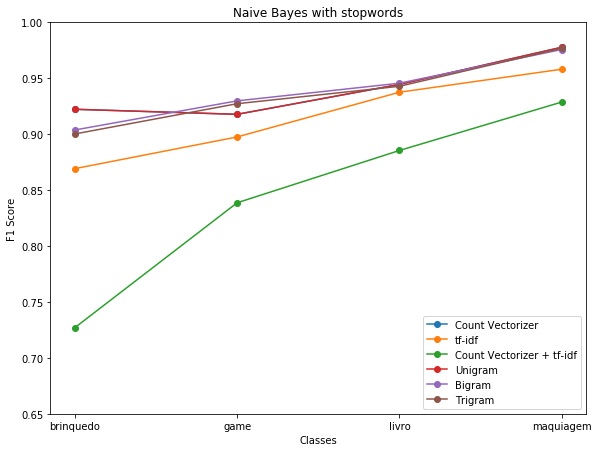

In [251]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('Naive Bayes with stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['brinquedo', 'game', 'livro', 'maquiagem'])
ax.set_xticks([0, 1, 2, 3])
ax.set_ylim([0.65,1])
ax.plot(experiment_11,marker="o",label='Count Vectorizer')
ax.plot(experiment_12,marker="o",label='tf-idf')
ax.plot(experiment_13,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_14,marker="o",label='Unigram')
ax.plot(experiment_15,marker="o",label='Bigram')
ax.plot(experiment_16,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

In [252]:
experiment_11_sw

array([0.93074119, 0.92243767, 0.94642857, 0.98409332])

In [253]:
experiment_12_sw

array([0.91254753, 0.91780822, 0.95780177, 0.96450939])

In [254]:
experiment_13_sw

array([0.8828125 , 0.91304348, 0.94083414, 0.95941727])

In [255]:
experiment_14_sw

array([0.93074119, 0.92243767, 0.94642857, 0.98409332])

In [256]:
experiment_15_sw

array([0.92670807, 0.94068966, 0.95592556, 0.97989418])

In [257]:
experiment_16_sw

array([0.9225    , 0.94101509, 0.95882353, 0.97993664])

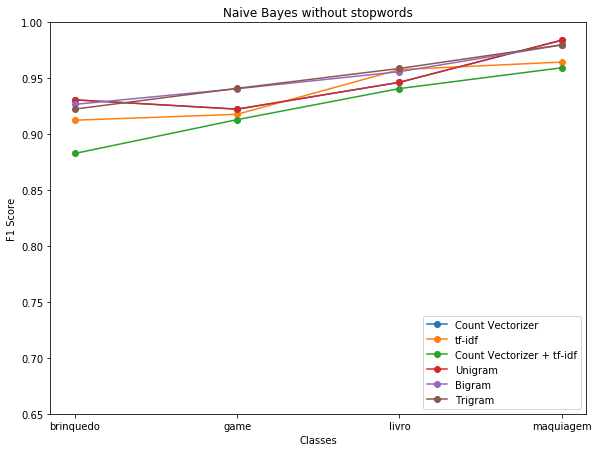

In [258]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('Naive Bayes without stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['brinquedo', 'game', 'livro', 'maquiagem'])
ax.set_xticks([0, 1, 2, 3])
ax.set_ylim([0.65,1])
ax.plot(experiment_11_sw,marker="o",label='Count Vectorizer')
ax.plot(experiment_12_sw,marker="o",label='tf-idf')
ax.plot(experiment_13_sw,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_14_sw,marker="o",label='Unigram')
ax.plot(experiment_15_sw,marker="o",label='Bigram')
ax.plot(experiment_16_sw,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

### Experimentos com SVM/SVC

In [259]:
experiment_21

array([0.81510934, 0.82565789, 0.92570281, 0.93002257])

In [260]:
experiment_22

array([0.9540636 , 0.94444444, 0.96340257, 0.97268908])

In [261]:
experiment_23

array([0.94424674, 0.9505814 , 0.96311067, 0.96049896])

In [262]:
experiment_24

array([0.81510934, 0.82565789, 0.92570281, 0.93002257])

In [263]:
experiment_25

array([0.816286  , 0.81983471, 0.92323232, 0.93736018])

In [264]:
experiment_26

array([0.81584158, 0.81530782, 0.91809909, 0.9375    ])

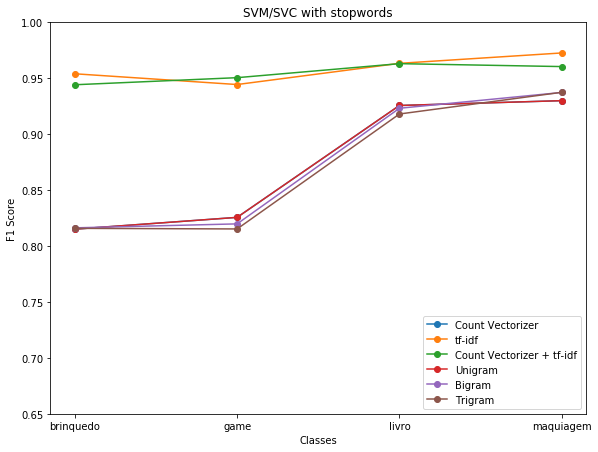

In [265]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('SVM/SVC with stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['brinquedo', 'game', 'livro', 'maquiagem'])
ax.set_xticks([0, 1, 2, 3])
ax.set_ylim([0.65,1])
ax.plot(experiment_21,marker="o",label='Count Vectorizer')
ax.plot(experiment_22,marker="o",label='tf-idf')
ax.plot(experiment_23,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_24,marker="o",label='Unigram')
ax.plot(experiment_25,marker="o",label='Bigram')
ax.plot(experiment_26,marker="o",label='Trigram')
plt.legend(loc=4)
plt.show()

In [266]:
experiment_21_sw

array([0.85773624, 0.89440994, 0.93172691, 0.93617021])

In [267]:
experiment_22_sw

array([0.95971564, 0.95930233, 0.96957802, 0.97989418])

In [268]:
experiment_23_sw

array([0.95539906, 0.96681097, 0.97492477, 0.96436059])

In [269]:
experiment_24_sw

array([0.85773624, 0.89440994, 0.93172691, 0.93617021])

In [270]:
experiment_25_sw

array([0.82985075, 0.87163233, 0.92307692, 0.92881356])

In [271]:
experiment_26_sw

array([0.8076555 , 0.85346216, 0.9125    , 0.91954023])

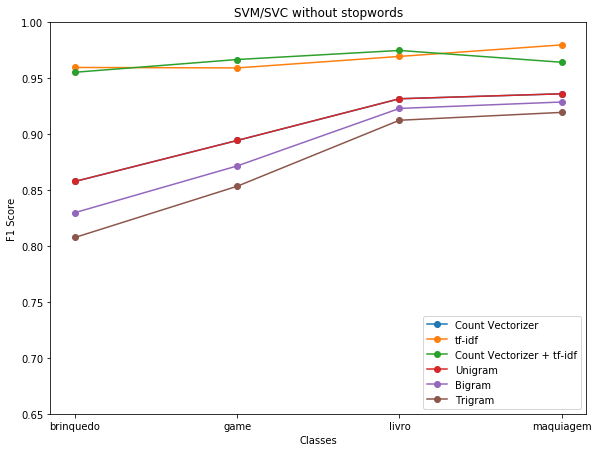

In [272]:
fig=plt.figure(figsize=[9.6, 7.2])
ax=fig.add_subplot(111)
ax.set_title('SVM/SVC without stopwords')
ax.set_xlabel('Classes')
ax.set_ylabel('F1 Score')
ax.set_xticklabels(['brinquedo', 'game', 'livro', 'maquiagem'])
ax.set_xticks([0, 1, 2, 3])
ax.set_ylim([0.65,1])
ax.plot(experiment_21_sw,marker="o",label='Count Vectorizer')
ax.plot(experiment_22_sw,marker="o",label='tf-idf')
ax.plot(experiment_23_sw,marker="o",label='Count Vectorizer + tf-idf')
ax.plot(experiment_24_sw,marker="o",label='Unigram')
ax.plot(experiment_25_sw,marker="o",label='Bigram')
ax.plot(experiment_26_sw,marker="o",label='Trigram')
plt.legend(loc=4)
def plt.show()

## Análise dos resultados

A partir dos resultados obtidos pelos experimentos, o experimento realizado com o modelo SVM/SVC, com o pré-processamento do *dataset* utilizando `TF-IDF Vectorizer`, foi o que obteve melhor resultado (a partir da métrica F1 Score). Entretanto, não houve ganhos significativos com a remoção das *stopwords* em língua portuguesa &mdash; houve ganhos, já que a métrica F1 Score apresentou melhor resultado, mas não foram estatisticamente significantes, em geral.